In [13]:
import sys
sys.path.append('../../../') # Add the root directory to sys.path

In [2]:
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from torchsummary import summary
from models.cnn import CNN
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [3]:
data_dir = '../../../data/Gaia DR3/LM_mass.parquet'

In [4]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,flux,spectraltype_esphs,mass_flame
0,2263623450631337088,"[2.4380569e-15, 2.2388932e-15, 2.0208773e-15, ...",F,1.364876
1,2263623484991072128,"[9.080353e-17, 7.900905e-17, 7.354385e-17, 7.6...",G,0.892899
2,2263625031179532800,"[4.1279026e-17, 3.6907568e-17, 3.8073304e-17, ...",G,0.988900
3,2263625649654599424,"[3.0394444e-17, 2.6702259e-17, 2.3652267e-17, ...",F,1.200995
4,2263626199410391424,"[5.687641e-18, 8.438833e-18, 6.6333053e-18, 4....",K,1.069875


In [5]:
df = data.drop(columns = ['spectraltype_esphs'])
df.head()

,source_id,flux,mass_flame
0,2263623450631337088,"[2.4380569e-15, 2.2388932e-15, 2.0208773e-15, ...",1.364876
1,2263623484991072128,"[9.080353e-17, 7.900905e-17, 7.354385e-17, 7.6...",0.892899
2,2263625031179532800,"[4.1279026e-17, 3.6907568e-17, 3.8073304e-17, ...",0.988900
3,2263625649654599424,"[3.0394444e-17, 2.6702259e-17, 2.3652267e-17, ...",1.200995
4,2263626199410391424,"[5.687641e-18, 8.438833e-18, 6.6333053e-18, 4....",1.069875


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   source_id   10000 non-null  int64  
 1   flux        10000 non-null  object 
 2   mass_flame  10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


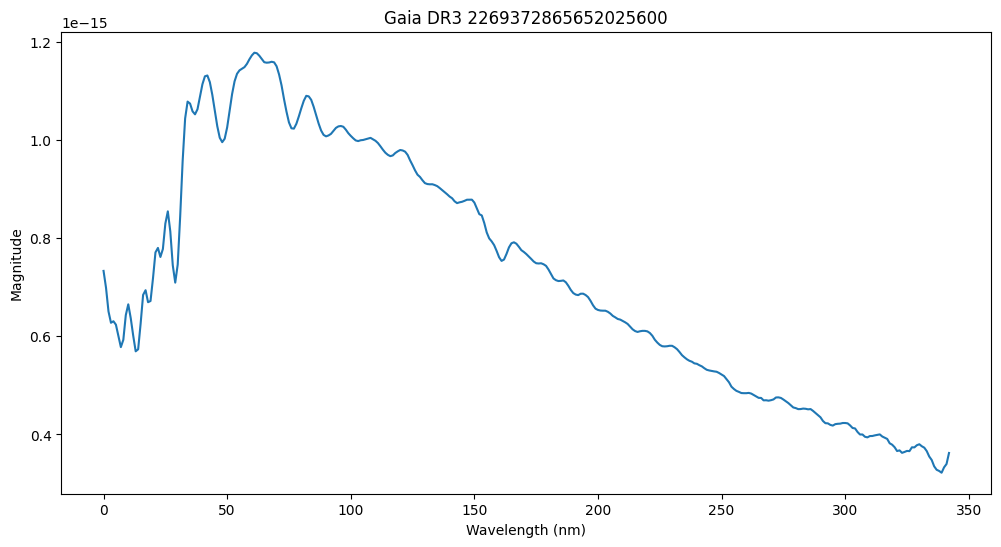

In [7]:
# rerun this cell to see random different spectra
sample_ms = df['flux'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

plt.figure(figsize=(12, 6))

plt.plot(flux_ms)
plt.title(f"Gaia DR3 {object_id_ms}")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.show()

In [8]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)

Number of total spectral samples: 10000
Number of bins in each spectra: 343


In [9]:
X = np.vstack(df['flux'])
y = torch.from_numpy(np.vstack(df['mass_flame'])).float()

# L2 normalization
X = torch.from_numpy(X/np.linalg.norm(X,keepdims=True)).float()

In [10]:
def extend_curves(curves):
    '''
    function to extended loss curves to the same length
    '''
    max_length = max(len(curve) for curve in curves)
    
    extended_curves = []
    for curve in curves:
        last_value = curve[-1]
        extended_curve = curve + [last_value] * (max_length - len(curve))
        extended_curves.append(extended_curve)
    
    return np.array(extended_curves)

def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
def fit_model(model, x_train, y_train, x_val, y_val, prt_steps = 1, verbose=True):
    
    # initialize weights
    model.apply(init_weights)

    # hyperparameters
    epochs = 200
    learning_rate = 1e-4
    batch_size = 32
    device = 'cuda'
    
    # early stopping
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # model components
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # move everything to gpu
    model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)

    # metrics
    training_losses, validation_losses = [], []
    
    # lr cycling
    max_lr = 1e-2
    steps_per_epoch = (len(x_train) + batch_size - 1) // batch_size
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs)

    batch_start = torch.arange(0, len(x_train), batch_size)

    for epoch in tqdm(range(epochs), desc='Epochs', dynamic_ncols=True):
        
        model.train()
        running_loss = 0

        for start in batch_start:

            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            output = model(x_batch.unsqueeze(1))
            loss = criterion(output, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * x_batch.size(0)

        train_loss = running_loss / len(x_train)
        training_losses.append(train_loss)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}', end='\r')


        model.eval()
        
        with torch.no_grad():
            
            output = model(x_val.unsqueeze(1))
            loss = criterion(output, y_val)
            
            val_loss = loss.item()
        
        validation_losses.append(val_loss)
        
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}', end='\r')    
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break
        
    return model, training_losses, validation_losses

In [11]:
kfold = KFold(n_splits=10)

training_losses_foldx, validation_losses_foldx, models = [], [], []

model = CNN()
summary(model)


for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    
    print(f"\nFitting fold {fold+1}")

    model, tr_loss, val_loss = fit_model(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx], prt_steps=1, verbose=True)
    models.append(model)
    training_losses_foldx.append(tr_loss)
    validation_losses_foldx.append(val_loss)

training_losses = np.mean(extend_curves(training_losses_foldx), axis=0)
validation_losses = np.mean(extend_curves(validation_losses_foldx), axis=0)

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            64
├─Conv1d: 1-2                            1,568
├─MaxPool1d: 1-3                         --
├─Linear: 1-4                            174,144
├─Linear: 1-5                            65
Total params: 175,841
Trainable params: 175,841
Non-trainable params: 0

Fitting fold 1


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.6202, Val Loss: 1.9838
Early stopping at epoch 13

Fitting fold 2


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.6072, Val Loss: 2.0603
Early stopping at epoch 22

Fitting fold 3


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.6234, Val Loss: 1.1293
Early stopping at epoch 19

Fitting fold 4


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.6084, Val Loss: 2.4254
Early stopping at epoch 14

Fitting fold 5


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.6333, Val Loss: 1.3886
Early stopping at epoch 13

Fitting fold 6


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.5776, Val Loss: 1.0263
Early stopping at epoch 30

Fitting fold 7


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.5718, Val Loss: 1.1591
Early stopping at epoch 14

Fitting fold 8


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.5492, Val Loss: 0.8577
Early stopping at epoch 36

Fitting fold 9


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.5800, Val Loss: 1.0101
Early stopping at epoch 15

Fitting fold 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.5294, Val Loss: 0.9312
Early stopping at epoch 13


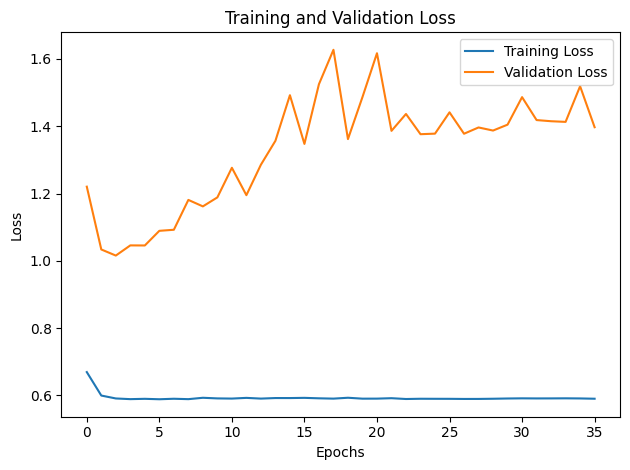

In [12]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()